# Natural Language Processing with Python

This notebook covers a number of common natural language processing (NLP) techniques in Python and follows the excellent [blog post](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e) by [Emmanuel Ameison](https://www.linkedin.com/in/ameisen/), Head of AI at Insight Data Science. Much of the code here is from the accompanying [Jupyter notebook](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb) by Emmanuel. 

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

Using TensorFlow backend.


## Loading and Cleaning Data

The data for this notebook will be the "disasters on social media" tweet dataset from [Figure Eight](https://www.figure-eight.com/data-for-everyone/), composed of ~10,000 tweets returned after searching for disaster-related keywords. Each tweet was then hand-labeled as actually referring to a disaster or instead referring to something else.  

Treating this as a classification problem, we would be interested in predicting the likelyhood that a particular tweet actually referred to a disaster. 

As a first step to clean the data, we copy the database to ``socialmedia_relevant_cols_decoded.csv``, using the ``codecs`` module to fix several encoding errors. We'll be working with the clean version of the tweets from here on out.

In [2]:
input_file = codecs.open('./socialmedia_relevant_cols.csv', 'r', encoding='utf-8', errors='replace')
output_file = open('./socialmedia_relevant_cols_decoded.csv', 'w')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
        
sanitize_characters(input_file, output_file)

input_file.close()
output_file.close()

If we take a look at the first few lines of the tweet database, we see that there are a number of things we'd like to fix before trying to train any model:

* Turning all characters to lowercase (for example 'Fire', 'FIRE', and 'fire' can be assumed to have the same meaning)
* Removing special characters (e.g., '.', '#', etc)
* Removing urls
* Removing '@' tags and changing '@' used as shorthand to "at" 

Cleaning our text in this way simplifies the process of vectorizing text features and training our models. 

Clearly there are other things we could do to clean our text (e.g., fixing typos, removing stop words, lemmatization) but this is a good first pass. 


In [3]:
tweet_db = pd.read_csv('./socialmedia_relevant_cols_decoded.csv')

tweet_db.head(10)

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1
5,All residents asked to 'shelter in place' are ...,Relevant,1
6,"13,000 people receive #wildfires evacuation or...",Relevant,1
7,Just got sent this photo from Ruby #Alaska as ...,Relevant,1
8,#RockyFire Update => California Hwy. 20 closed...,Relevant,1
9,Apocalypse lighting. #Spokane #wildfires,Relevant,1


And now our cleaned text:

In [4]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

tweet_db_clean = standardize_text(tweet_db, "text")

tweet_db_clean.to_csv("socialmedia_relevant_cols_clean.csv")
tweet_db_clean.head(10)

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1
5,all residents asked to 'shelter in place' are ...,Relevant,1
6,"13,000 people receive wildfires evacuation or...",Relevant,1
7,just got sent this photo from ruby alaska as ...,Relevant,1
8,rockyfire update california hwy 20 closed...,Relevant,1
9,apocalypse lighting spokane wildfires,Relevant,1


Our pandas dataframe now consists of a column with strings of cleaned text (the tweets) and two columns indicating the relevancy/class label of the tweet. 

We'd like to work towards a numeric representation of each tweet. As a first step, we want to tokenize our tweets, splitting them into lists of words. 

In [5]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

tweet_db_clean["tokens"] = tweet_db_clean["text"].apply(tokenizer.tokenize)
tweet_db_clean.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


Let's take a look some high level summary statistics of cleaned text dataset to get an idea of what we're working with:

In [6]:
all_words = [word for tokens in tweet_db_clean["tokens"] for word in tokens] # add all words to a list
tweet_lengths = [len(tokens) for tokens in tweet_db_clean["tokens"]] # count lengths of tokenized tweets
vocab = sorted(list(set(all_words))) # list of unique words
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(tweet_lengths))

154724 words total, with a vocabulary size of 18101
Max sentence length is 34


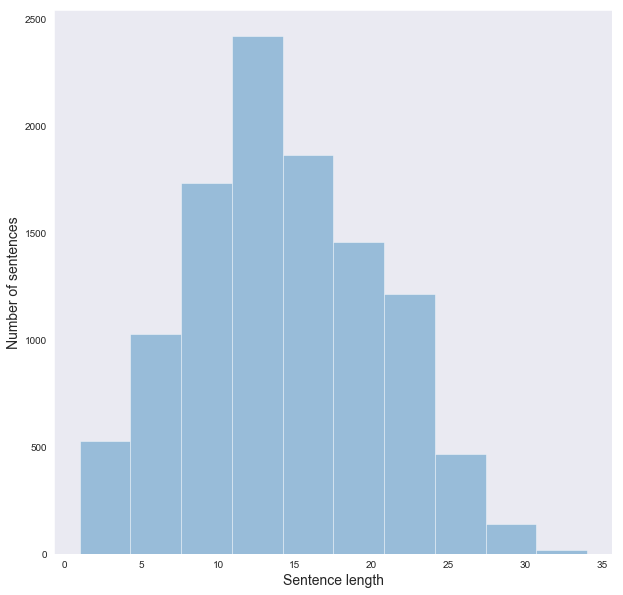

In [7]:
fig = plt.figure(figsize=(10, 10)) 
sns.distplot(tweet_lengths, kde=False, bins=10)
plt.xlabel('Sentence length', fontsize=14)
plt.ylabel('Number of sentences', fontsize=14)
plt.show()

From the histogram of sentence lengths above, we can see that most tweets consist of around 14 words. Because of the twitter character limit, we'd expect most tweets to be around this length (remember we removed a lot of special characters and whitespace, which count toward the tweet character limit).

We're almost ready to implement our first NLP model! As a final step, let's split our data into training and test sets. 

In [8]:
from sklearn.model_selection import train_test_split

list_corpus = tweet_db_clean["text"].tolist()
list_labels = tweet_db_clean["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)



## Modeling: Bag of Words

With our cleaned and tokenized tweets, we can start trying to train models to predict whether or not a tweet is disaster-related. 

As mentioned previously, the first (and arguably most important!) step in this process is to generate *word embeddings*, or numeric representations of our text. If we can intelligently convert our text features to numeric representations, then we can use those representations as inputs into virtually any classification model we want. 

On the flipside, however, if we don't generate word embeddings that clearly separate sentences with different meaning, then it will be very difficult for our classification model to predict tweet topic. The "garbage in, garbage out" adage definitely holds here. 

The first and simplest way of generating word embeddings is to use a *Bag of Words*. This is essentially one-hot encoding each sentence, where each word is a category. Using bag of words, each tweet will be converted to a vector of length *N*, where *N* is the number of unique words in our entire corpus (all tweets). Each word in the tweet will be represented by a 1 in the position in the vector corresponding to that particular word. If a word is in the tweet twice, then the vector entry corresponding to that word will be 2, and so on and so forth. 

There are clear limitations to this approach, namely:
* Word order information is discarded
* A word needs to be in the corpus we trained our bag of words on
* Dimensionality increases as the number of unique words increases

However, Bag of Words is very simple to implement so we'll start with it. 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    embed = count_vectorizer.fit_transform(data)
    return embed, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

We now have a very large, very sparse matrix. Let's visualize the disaster-related and unrelated classifications in the first two dimensions of PCA space. 

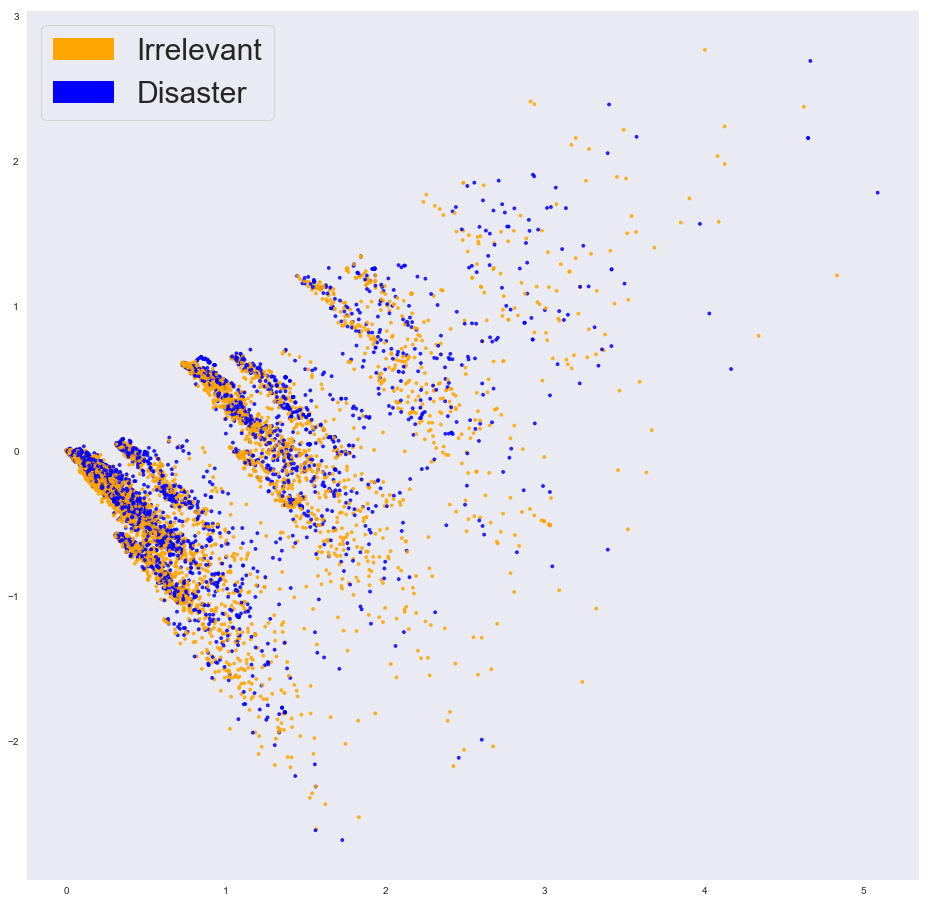

In [10]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_PCA(test_data, test_labels, plot=True):
        pca = TruncatedSVD(n_components=2)
        pca.fit(test_data)
        pca_scores = pca.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(pca_scores[:,0], pca_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_PCA(X_train_counts, y_train)
plt.show()

There's definitely some substructure, and visible differences between the irrelevant and disaster classes, but overall the separation isn't great.

Nevertheless, we have successfully created word embeddings. These can be used as features for a classification model. As a first pass, we can train a simple, yet typically adequate logistic regression model. 

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

If we were solving a real data science problem, we'd want to dig into the classifier results, but since we're just comparing various NLP methods here, we'll look at classification accuracy on our holdout test set. 

In [12]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_predicted_counts)
print("accuracy = ", accuracy)

accuracy =  0.7734375


An accuracy of 77% percent isn't too shabby given the simplicity of our word embeddings, and depending on the use case could be sufficient. But we can probably do better. 

Before moving onto other models, let's examine the feature importances.

In [13]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

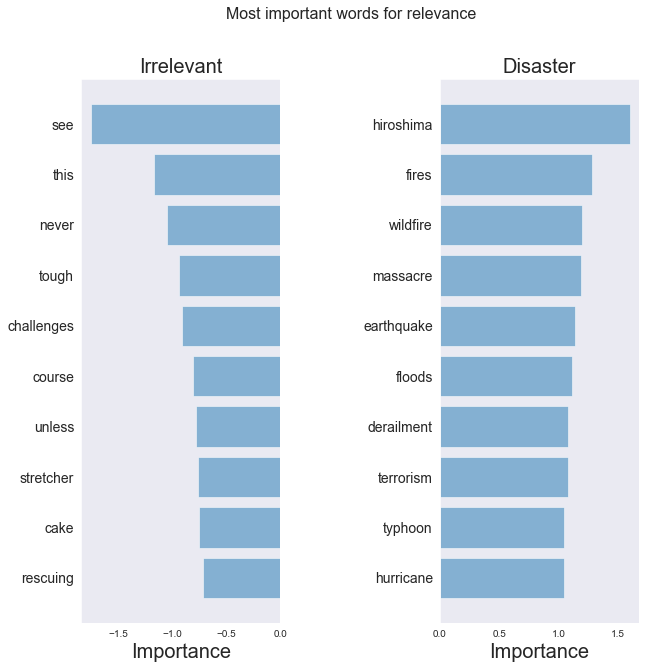

In [14]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

There's definitely some signal here - clearly our model is picking up on the fact that words like "fire" and "earthquake" indicate a tweet is actually about a disaster.

It's a bit more difficult to interpret the words important for the irrelevant tweets. Clearly "cake" might indicate a non-disaster related tweet, but words like "rescuing" and "this" seem like they could pertain to disaster tweets as well. 

We would naively expect that a confusion matrix would reveal that false negatives proportionally outweight false positives, since disaster-related tweets with words like "this" or "rescuing" might be classified as irrelevant:

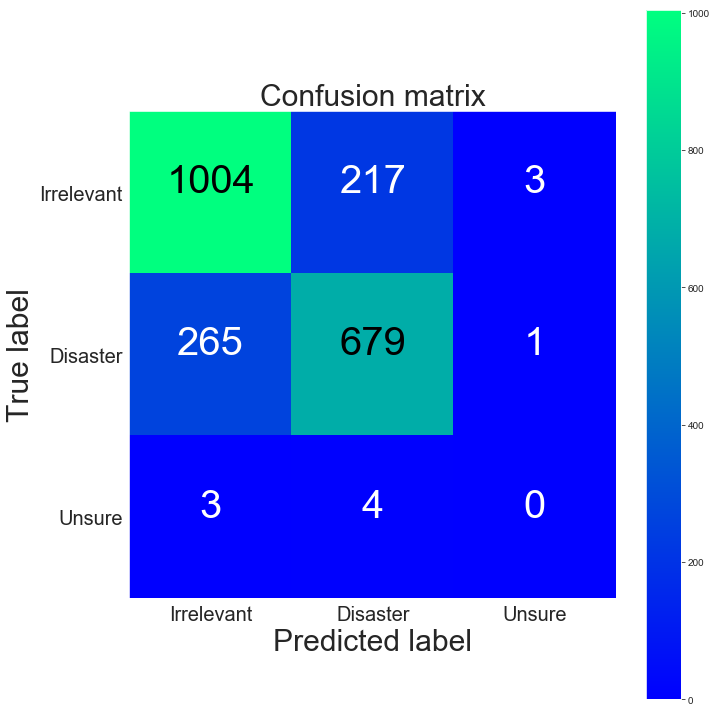

[[1004  217    3]
 [ 265  679    1]
 [   3    4    0]]


In [15]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Indeed, we see that about 1/4 of disaster-related tweets were classified as irrelevant, while only 1/6 of irrelevant tweets were classified as being disaster-related. 

Let's move to a more complex word embedding method.

## Modeling: TF-IDF

Remember that words like "see" and "this" had high weights in our logistic regression model trained on our bag of words embeddings. These are common words in the English language and have very little meaning without any additional context, so we would expect them to not play a role in determining whether or not a tweet is disaster-related. 

In other words, our intuition tells us that these words shouldn't have high weights, meaning that our classifier is merely overfitting on common words in our corpus. 

Enter TF-IDF, which stands for *term frequency - inverse document frequency*. TF-IDF adjusts the weights assigned to each word in our corpus in proportion to how frequently they occur in the corpus (the classic formulation is *term frequency* divided by *document frequency*), and can be applied to our bag of words embeddings we already have.  

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=False)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Let's go ahead and see our PCA plot again:

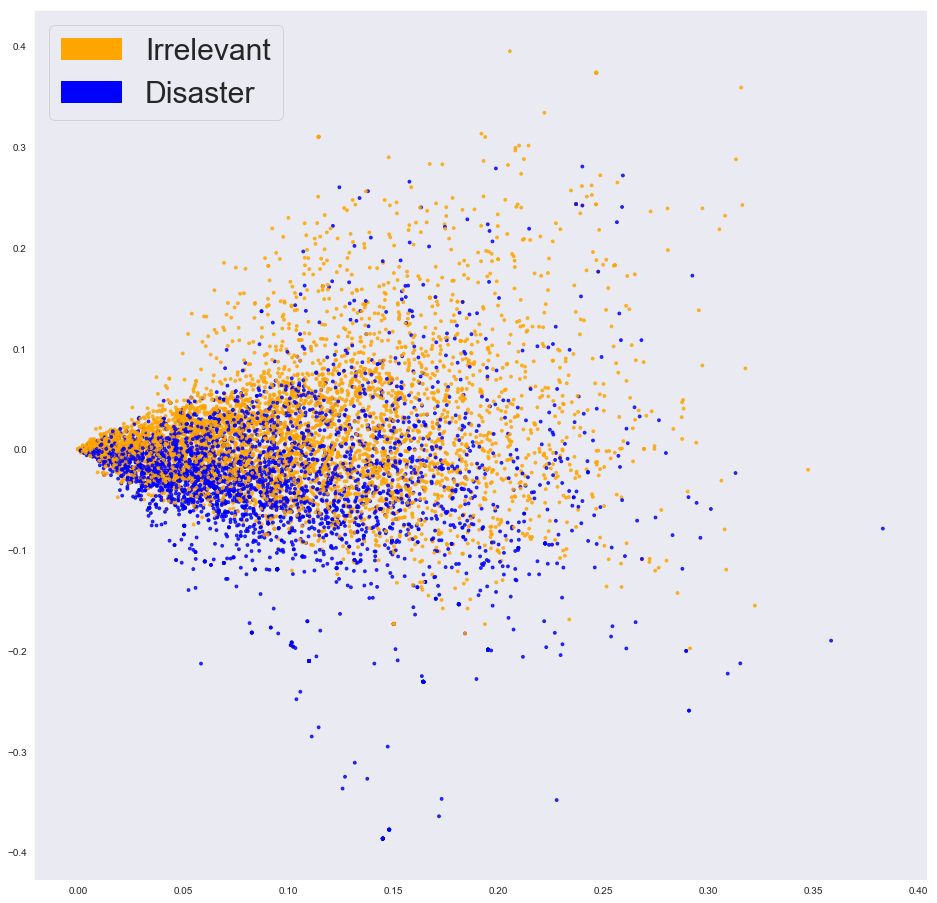

In [17]:
fig = plt.figure(figsize=(16, 16))          
plot_PCA(X_train_tfidf, y_train)
plt.show()

There is clearly better separation between our two classes now. Let's see how a logistic regression model shakes out now. 

In [18]:
clf_tfidf = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_test, y_predicted_tfidf)
print("accuracy = ", accuracy_tfidf)

accuracy =  0.7849264705882353


Accuracy is only slightly better, but let's see about those feature importances.

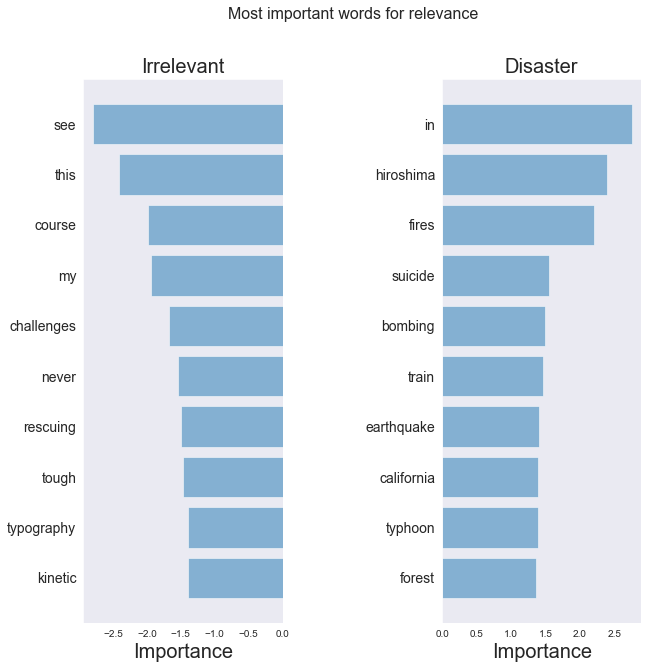

In [19]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores_tfidf = [a[0] for a in importance_tfidf[1]['tops']]
top_words_tfidf = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores_tfidf = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words_tfidf = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores_tfidf, top_words_tfidf, bottom_scores_tfidf, bottom_words_tfidf,
                     "Most important words for relevance")

These results are pretty interesting - we see that our original hunch that "see" and "this" were the results of overfitting common words doesn't seem to shake out, as they remain the most important words even after TF-IDF. 

On the other hand, we see that the word "in" has rocketed to the top of the disaster feature importances. 

Two possible explanations for this non-intuitive behavior:
* The important words aren't as common as assumed in the corpus and don't get substantively de-weighted by TF-IDF
* Tweets with these words truly tend to belong to their respective classes. 

The fact that accuracy is 78% suggests the second case, but if we were working on a data science problem in the wild we'd want to investigate further. For now let's move onto our next model. 

## Modeling: word2vec

Remember that even after we applied TF-IDF, our word embeddings were fundamentally created by counting instances of words in each sentence. This is a relatively crude method that clearly works, but ignores most of the aspects of what makes language what it is. 

Ideally, we'd like our word embeddings to encode meaning and context, rather than simply being a count of whether or not a given word occurs. If we think of our bag of words embeddings as being vectors of length 1 in an N-dimensional space, where N is again the total number of words in our corpus, then we know that each vector under this embedding model lies along one of the N basis vectors forming this space. Thus, each unique word in our corpus is linearly independent.

But intuitively, words *shouldn't* be linearly independent. For example, the word "cat" could be thought of as a linear combination of the words "pet" and "furry". The word "dog" should also be a slightly different linear combination of "pet" and "furry", and the vectors for both "cat" and "dog" should be nearly orthogonal to the vector for "airplane", which could plausibly be a combination of "metal" and "bird". Certainly this is a crude example, but the general idea holds - some words are closer in meaning than others, and we'd like to encode that information into our embedding model. 

Enter word2vec, a word embedding model that incorporates this info. Under word2vec, words are represented by vectors in some high-dimensional space, but unlike our simple bag of words embeddings, words with similar meanings have similar vectors, vs. words with very different meanings. 

But how do you generate these vectors? There are [several ways](https://en.wikipedia.org/wiki/Word2vec#Training_algorithm), but they all rely on the fact that words surrounding the word to be embedded provide context for a given word's meaning. Thus, the vectors in a word2vec model are, strictly speaking, indicators of the context in which a given word is typically used. That is, if two words have similar vectors, then they are used in similar contexts. In terms of how this is implemented, word2vec models are typically neural networks, trained to either predict contextual words from the word to be embedded, or vice versa. 

Here, we use a pre-trained word2vec model from Google. To keep things simpler, we'll just average the vectors for all the words in each tweet. 

In [20]:
import gensim

word2vec_path = "./GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

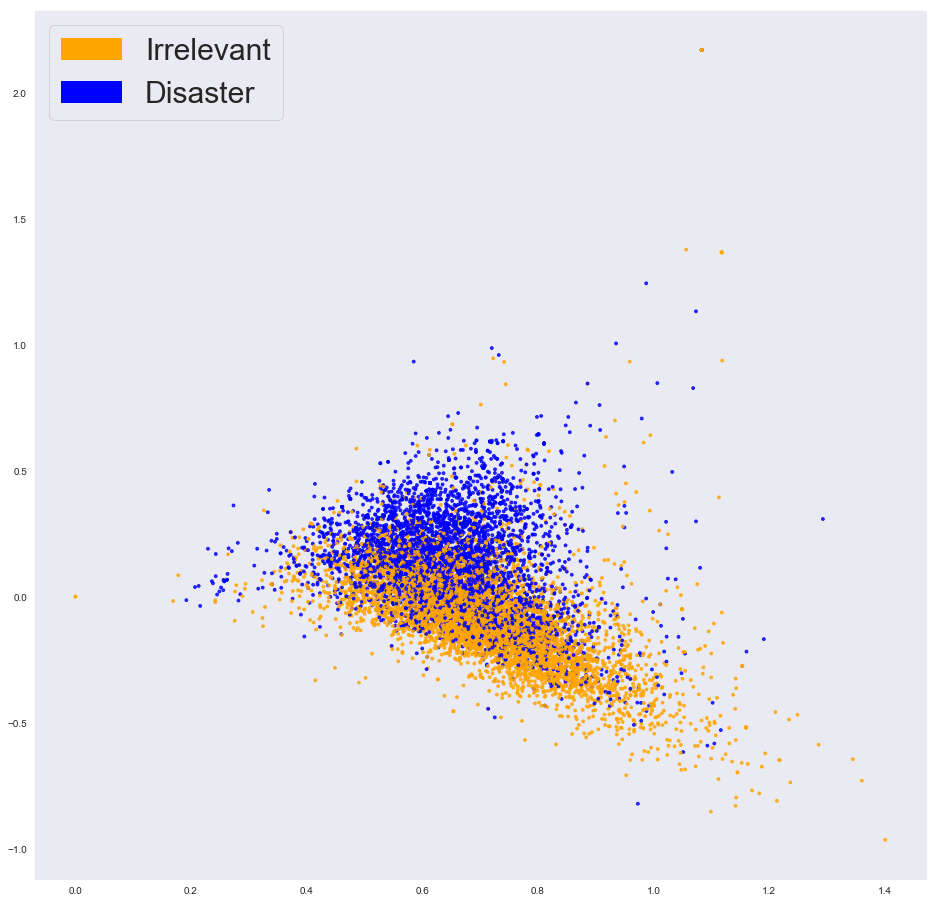

In [21]:
embeddings = get_word2vec_embeddings(word2vec, tweet_db_clean)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

fig = plt.figure(figsize=(16, 16))          
plot_PCA(embeddings, list_labels)
plt.show()

Compared to our bag of words + TF-IDF word embeddings, the PCA plot for our word2vec embeddings shows that disaster and irrelevant tweets are even more separated. Let's train our logistic regression model and examine the results!

In [22]:
clf_w2v = LogisticRegression(class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

accuracy_word2vec = accuracy_score(y_test, y_predicted_word2vec)
print("accuracy = ", accuracy_word2vec) 

accuracy =  0.7789522058823529


We see that our accuracy is actually slightly worse than our TF-IDF approach. Recall though, that we used a pretrained word2vec model from Google. This model wasn't trained on tweets, which we can assume to have distinctive patterns (i.e. much more slang, shorthand, etc.) vs. the Google News dataset that was used for training the word2vec model, which likely consists of English written in a journalistic style. 

Still, let's see some feature importances. We'll have to use the LIME module ([*Local Interpretable Model-agnostic Explanations*](https://arxiv.org/pdf/1602.04938.pdf), a black-box explainer, since the word2vec model is significantly harder to parse than our bag of words model.

What follows is code shamelessly copied from Emmanuel's blog:

In [23]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import random
from collections import defaultdict

random.seed(40)

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

/Users/donald/anaconda3/envs/condaenv/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Now let's visualize feature importances:

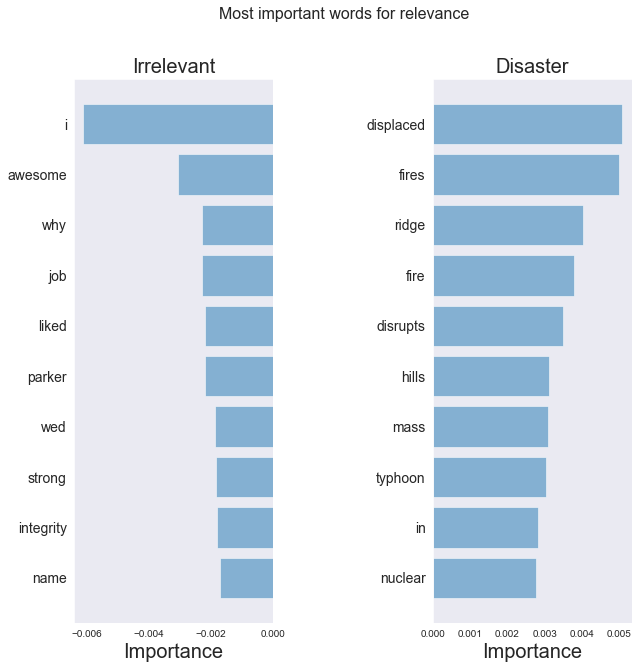

In [24]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

These feature importances make sense! There are some odd words, like "in" and "i", but largely the most important words agree with our intuition.

If we were to stick with word2vec, one thing we'd want to do is either use a model trained on language similar to tweets or train our own word2vec model. 

## Conclusion

In this notebook, I worked through some common NLP techniques in Python, namely:
* Basic text preprocessing
* A simple bag of words embedding model
* TF-IDF + bag of words
* word2vec embeddings

These are basic techniques - it's important to note that they are all relatively crude in the context of the complexities of natural language. Crucially, the embeddings we used don't really incorporate much contextual information, and they don't include memory, both of which are fundamental to language. There is a lot of current work to use deep learning for NLP and state-of-the-art models incorporate varying degrees of contextualization and memory. 

Credit: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb